In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
transform = transforms.ToTensor()

train_ds = datasets.FashionMNIST('data', train=True, download=True, transform=transform)
test_ds  = datasets.FashionMNIST('data', train=False, download=True, transform=transform)

print(len(train_ds), len(test_ds))

60000 10000


In [3]:
classes = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

In [4]:
minority_class = 7     # bag
minority_keep  = 300   # keep only 300 bags in training
other_keep     = 4000  # keep up to 4000 from each other class

targets = train_ds.targets
idx_all = []

for c in range(10):
    idx_c = torch.where(targets == c)[0]
    if c == minority_class:
        idx_all.append(idx_c[:minority_keep])
    else:
        idx_all.append(idx_c[:other_keep])

idx_all = torch.cat(idx_all)
imbal_train_ds = data.Subset(train_ds, idx_all)

train_loader = data.DataLoader(imbal_train_ds, batch_size=128, shuffle=True, drop_last=True)
test_loader  = data.DataLoader(test_ds, batch_size=256, shuffle=False)

print("Imbalanced train size:", len(imbal_train_ds))

Imbalanced train size: 36300


In [5]:
counts = torch.zeros(10, dtype=torch.int32)
for _, y in train_loader:
    for c in range(10):
        counts[c] += (y == c).sum().cpu()
print({classes[i]: int(counts[i]) for i in range(10)})

{'T-shirt/top': 3993, 'Trouser': 3991, 'Pullover': 3994, 'Dress': 3990, 'Coat': 3992, 'Sandal': 3990, 'Shirt': 3988, 'Sneaker': 300, 'Bag': 3993, 'Ankle boot': 3993}


In [6]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

def train_classifier(model, loader, epochs=5, lr=1e-3):
    model.train()
    opt = optim.Adam(model.parameters(), lr=lr)
    ce = nn.CrossEntropyLoss()
    for ep in range(1, epochs+1):
        total_loss = 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            logits = model(x)
            loss = ce(logits, y)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        print(f"Epoch {ep}/{epochs} loss={total_loss/len(loader):.4f}")

@torch.no_grad()
def eval_classifier(model, loader, minority_class=None):
    model.eval()
    correct = 0
    total = 0

    # minority stats
    m_correct = 0
    m_total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        pred = model(x).argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.numel()

        if minority_class is not None:
            mask = (y == minority_class)
            m_total += mask.sum().item()
            m_correct += ((pred == y) & mask).sum().item()

    acc = correct / total
    if minority_class is None or m_total == 0:
        return acc, None
    return acc, (m_correct / m_total)

baseline_clf = Classifier().to(device)
train_classifier(baseline_clf, train_loader, epochs=5)

acc, minority_acc = eval_classifier(baseline_clf, test_loader, minority_class=minority_class)
print("Baseline test accuracy:", acc)
print(f"Baseline minority ({classes[minority_class]}) accuracy:", minority_acc)

Epoch 1/5 loss=0.6557
Epoch 2/5 loss=0.4334
Epoch 3/5 loss=0.3825
Epoch 4/5 loss=0.3464
Epoch 5/5 loss=0.3252
Baseline test accuracy: 0.8467
Baseline minority (Sneaker) accuracy: 0.692


In [7]:
# build indices of minority class within the imbalanced subset
subset_indices = torch.tensor(idx_all)  # original indices in train_ds
minority_mask = (train_ds.targets[subset_indices] == minority_class)
minority_subset = data.Subset(train_ds, subset_indices[minority_mask].tolist())

minority_loader = data.DataLoader(minority_subset, batch_size=128, shuffle=True, drop_last=True)
print("Minority-only train size:", len(minority_subset))

Minority-only train size: 300


/tmp/ipython-input-2472909238.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  subset_indices = torch.tensor(idx_all)  # original indices in train_ds


In [8]:
latent_dim = 100
img_dim = 28*28

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 256), nn.ReLU(True),
            nn.Linear(256, 512), nn.ReLU(True),
            nn.Linear(512, 1024), nn.ReLU(True),
            nn.Linear(1024, img_dim),
            nn.Sigmoid()  # output [0,1] to match ToTensor
        )
    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(img_dim, 512), nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256), nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1)  # logits
        )
    def forward(self, x):
        if x.dim() == 4:
            x = x.view(x.size(0), -1)
        return self.net(x)

G = Generator().to(device)
D = Discriminator().to(device)

GAN Epoch 1/60 | D=1.3011 | G=0.9508


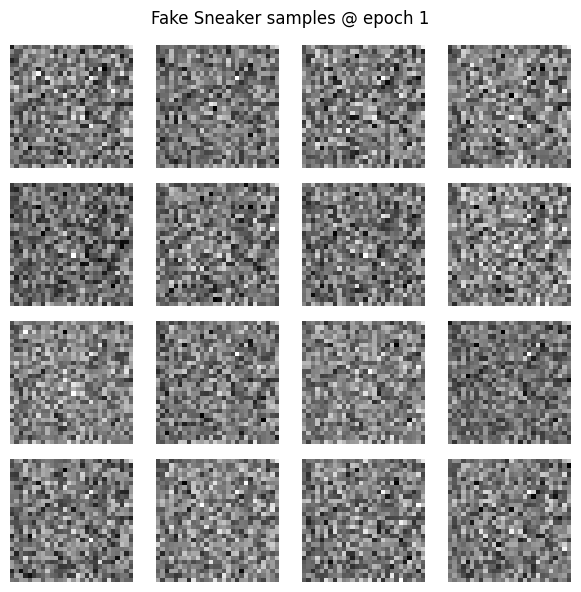

GAN Epoch 5/60 | D=0.7104 | G=2.1483


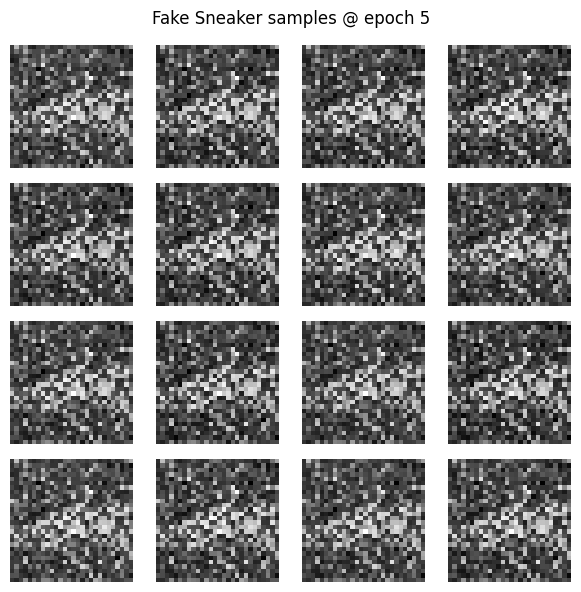

GAN Epoch 10/60 | D=0.9621 | G=1.5263


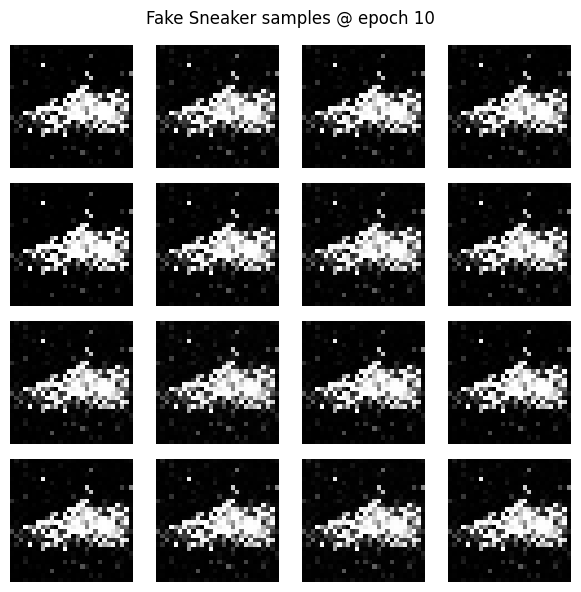

GAN Epoch 15/60 | D=1.3027 | G=1.3409


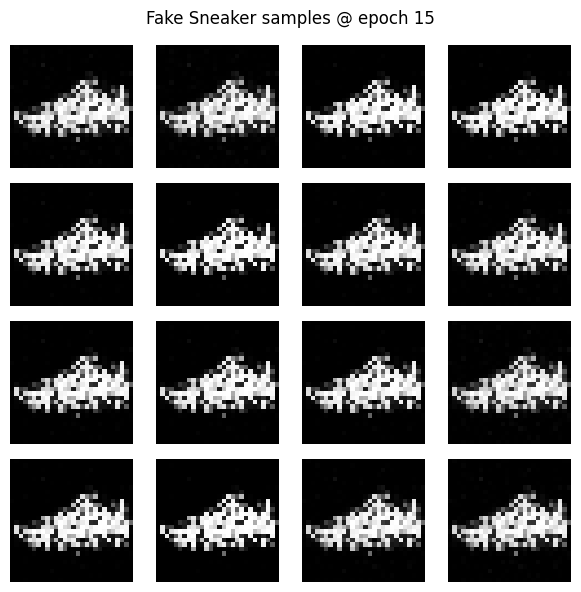

GAN Epoch 20/60 | D=1.4354 | G=1.3291


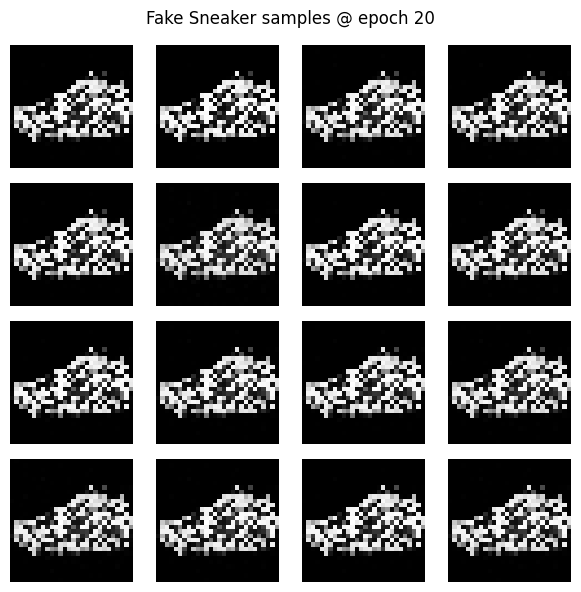

GAN Epoch 25/60 | D=1.0435 | G=1.6731


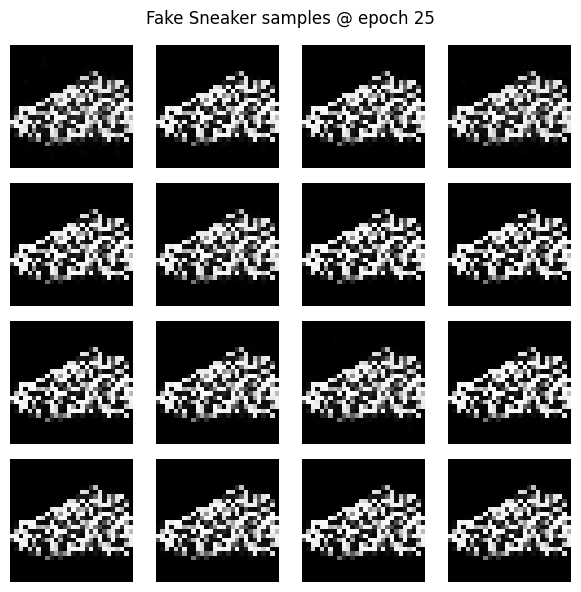

GAN Epoch 30/60 | D=0.9998 | G=1.8698


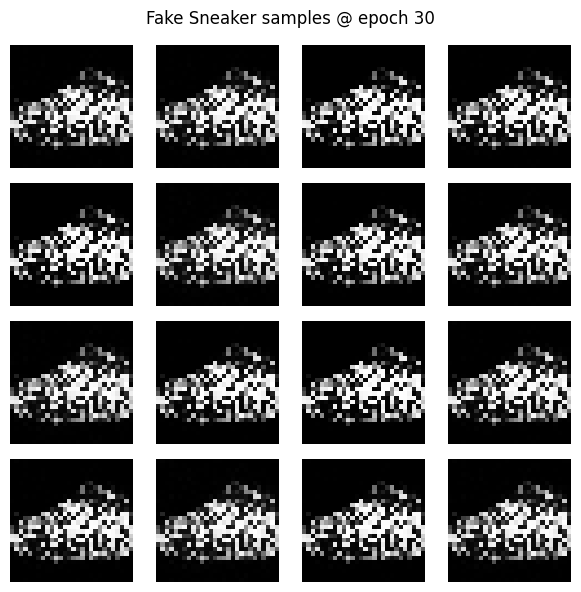

GAN Epoch 35/60 | D=1.4065 | G=1.3112


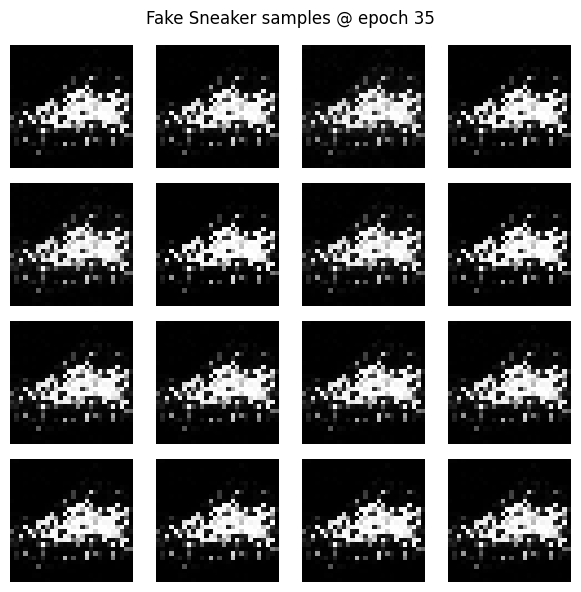

GAN Epoch 40/60 | D=1.2998 | G=1.2249


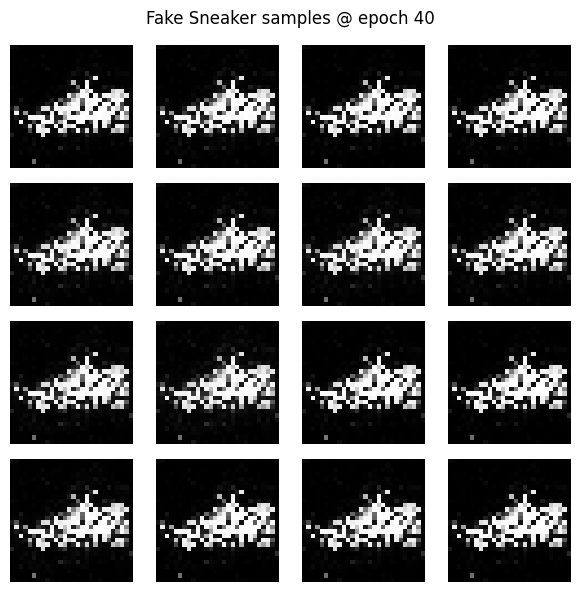

GAN Epoch 45/60 | D=1.1740 | G=1.4607


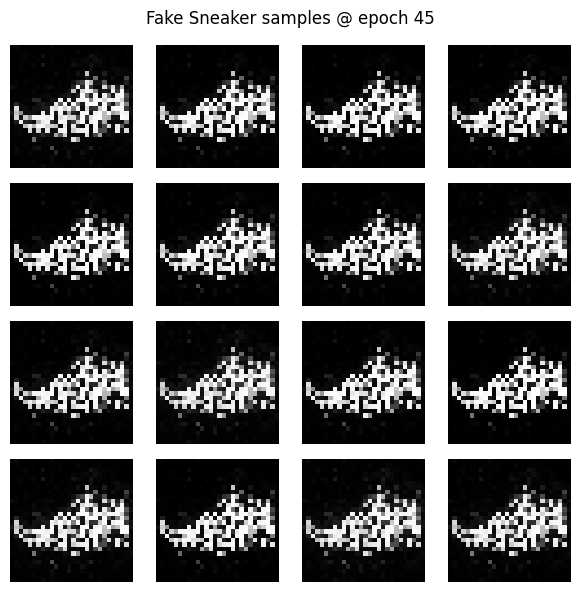

GAN Epoch 50/60 | D=1.0105 | G=1.6973


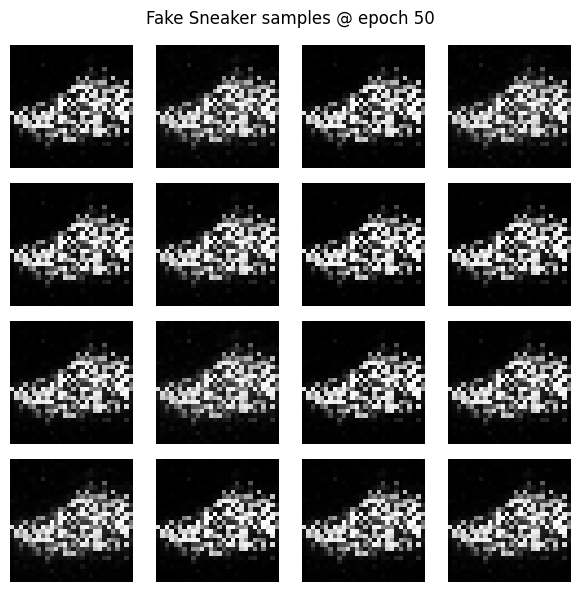

GAN Epoch 55/60 | D=1.1180 | G=1.5453


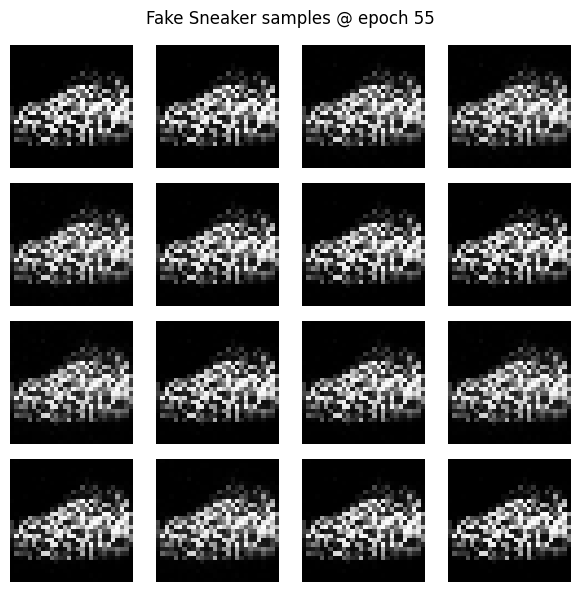

GAN Epoch 60/60 | D=1.1105 | G=1.3730


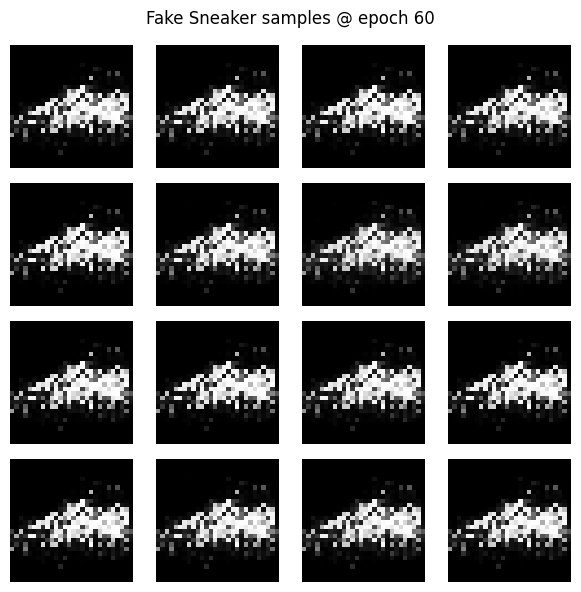

In [9]:
bce = nn.BCEWithLogitsLoss()
opt_g = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_d = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

gan_epochs = 60

def show_gan_samples(epoch, n=16):
    G.eval()
    with torch.no_grad():
        z = torch.randn(n, latent_dim, device=device)
        fake = G(z).view(n, 1, 28, 28).cpu()
    G.train()
    plt.figure(figsize=(6,6))
    for i in range(n):
        plt.subplot(4,4,i+1)
        plt.imshow(fake[i,0], cmap="gray")
        plt.axis("off")
    plt.suptitle(f"Fake {classes[minority_class]} samples @ epoch {epoch}")
    plt.tight_layout()
    plt.show()

for epoch in range(1, gan_epochs+1):
    for real, _ in minority_loader:
        real = real.to(device)
        real_flat = real.view(real.size(0), -1)

        # Train D
        opt_d.zero_grad()
        y_real = torch.full((real.size(0), 1), 0.9, device=device)  # label smoothing
        y_fake = torch.zeros(real.size(0), 1, device=device)

        loss_real = bce(D(real_flat), y_real)

        z = torch.randn(real.size(0), latent_dim, device=device)
        fake_flat = G(z).detach()
        loss_fake = bce(D(fake_flat), y_fake)

        loss_d = loss_real + loss_fake
        loss_d.backward()
        opt_d.step()

        # Train G
        opt_g.zero_grad()
        z = torch.randn(real.size(0), latent_dim, device=device)
        fake_flat = G(z)
        loss_g = bce(D(fake_flat), torch.ones(real.size(0), 1, device=device))
        loss_g.backward()
        opt_g.step()

    if epoch == 1 or epoch % 5 == 0:
        print(f"GAN Epoch {epoch}/{gan_epochs} | D={loss_d.item():.4f} | G={loss_g.item():.4f}")
        show_gan_samples(epoch)

In [10]:
def generate_filtered_synth(G, D, minority_class, n_keep=500, pool=5000):
    G.eval(); D.eval()
    with torch.no_grad():
        z = torch.randn(pool, latent_dim, device=device)
        fake = G(z) # (pool, 784)
        logits = D(fake)
        scores = torch.sigmoid(logits).squeeze()

        topk = torch.topk(scores, k=n_keep).indices
        best = fake[topk].cpu().view(n_keep, 1, 28, 28)

    labels = torch.full((n_keep,), minority_class, dtype=torch.long)
    return best, labels

In [11]:
n_synth = minority_keep
pool_size = 10 * n_synth

synth_imgs, synth_labels = generate_filtered_synth(
    G,
    D,
    minority_class,
    n_keep=n_synth,
    pool=pool_size
)

print("Filtered synthetic images:", synth_imgs.shape)

Filtered synthetic images: torch.Size([300, 1, 28, 28])


In [12]:
class TensorDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Extract ALL images from imbalanced subset into tensors
real_X = []
real_y = []
for x, y in data.DataLoader(imbal_train_ds, batch_size=512, shuffle=False):
    real_X.append(x)
    real_y.append(y)
real_X = torch.cat(real_X, dim=0)
real_y = torch.cat(real_y, dim=0)

aug_X = torch.cat([real_X, synth_imgs], dim=0)
aug_y = torch.cat([real_y, synth_labels], dim=0)

aug_train_ds = TensorDataset(aug_X, aug_y)
aug_train_loader = data.DataLoader(aug_train_ds, batch_size=128, shuffle=True, drop_last=True)

print("Augmented train size:", len(aug_train_ds))

Augmented train size: 36600


In [13]:
aug_clf = Classifier().to(device)
train_classifier(aug_clf, aug_train_loader, epochs=5)

acc2, minority_acc2 = eval_classifier(aug_clf, test_loader, minority_class=minority_class)
print("Augmented test accuracy:", acc2)
print(f"Augmented minority ({classes[minority_class]}) accuracy:", minority_acc2)

Epoch 1/5 loss=0.6442
Epoch 2/5 loss=0.4238
Epoch 3/5 loss=0.3790
Epoch 4/5 loss=0.3433
Epoch 5/5 loss=0.3253
Augmented test accuracy: 0.8595
Augmented minority (Sneaker) accuracy: 0.802


In [14]:
@torch.no_grad()
def per_class_accuracy(model, loader):
    model.eval()
    correct = torch.zeros(10)
    total = torch.zeros(10)
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        pred = model(x).argmax(1)
        for c in range(10):
            mask = (y == c)
            total[c] += mask.sum().item()
            correct[c] += ((pred == y) & mask).sum().item()
    return (correct / total).cpu().numpy()

accs_base = per_class_accuracy(baseline_clf, test_loader)
accs_aug  = per_class_accuracy(aug_clf, test_loader)

print("Base minority acc:", accs_base[minority_class])
print("Aug  minority acc:", accs_aug[minority_class])

Base minority acc: 0.692
Aug  minority acc: 0.802
